In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def rgb_to_ycocg_r(img):
    R = img[:, :, 0].astype(np.int32)
    G = img[:, :, 1].astype(np.int32)
    B = img[:, :, 2].astype(np.int32)

    # Forward transform (YCoCg-R)
    Co = R - B
    t  = B + (Co >> 1)
    Cg = G - t
    Y  = t + (Cg >> 1)

    return Y, Co, Cg


def normalize_channel(channel):
    ch_min = channel.min()
    ch_max = channel.max()

    # Avoid division by zero
    if ch_max == ch_min:
        return np.zeros_like(channel, dtype=np.uint8)

    # Scale to 0–255
    norm = (channel - ch_min) * (255.0 / (ch_max - ch_min))
    return norm.astype(np.uint8)


def show_image(title, img, cmap=None):
    plt.figure(figsize=(5,5))
    plt.title(title)
    if cmap is not None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.axis("off")
    plt.show()


In [5]:
def false_color_co(Co):
    """Map Co to orange-blue color."""
    norm = normalize_channel(Co)
    rgb = np.zeros((norm.shape[0], norm.shape[1], 3), dtype=np.uint8)
    rgb[:, :, 0] = norm          # R
    rgb[:, :, 1] = 128           # fixed mid green
    rgb[:, :, 2] = 255 - norm    # B (complement)
    return rgb

def false_color_cg(Cg):
    """Map Cg to green-magenta color."""
    norm = normalize_channel(Cg)
    rgb = np.zeros((norm.shape[0], norm.shape[1], 3), dtype=np.uint8)
    rgb[:, :, 0] = 255 - norm    # R (complement)
    rgb[:, :, 1] = norm          # G
    rgb[:, :, 2] = 255 - norm    # B (magenta mix)
    return rgb

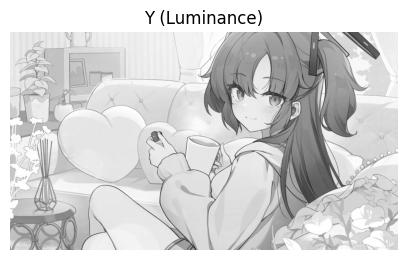

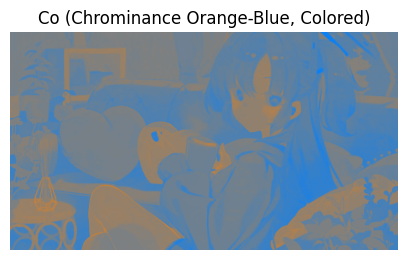

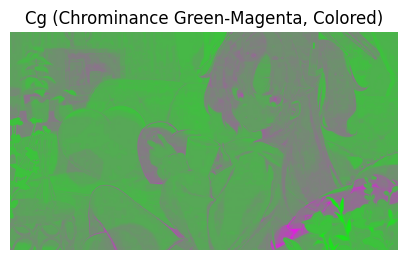

Berhasil disimpan: Y.png, Co.png, Cg.png


In [6]:
dir = "img/"
input_path = dir + "mybini.png"

img = Image.open(input_path).convert("RGB")
img_np = np.array(img)

Ye, Co, Cg = rgb_to_ycocg_r(img_np)

# Normalize grayscale (untuk tampilan asli)
Y_norm  = normalize_channel(Ye)
Co_norm = normalize_channel(Co)
Cg_norm = normalize_channel(Cg)

# False-color visualization
Co_color = false_color_co(Co)
Cg_color = false_color_cg(Cg)

# ===== SHOW IMAGES =====
show_image("Y (Luminance)", Y_norm, cmap='gray')
show_image("Co (Chrominance Orange-Blue, Colored)", Co_color)
show_image("Cg (Chrominance Green-Magenta, Colored)", Cg_color)

# ===== SAVE OUTPUT =====
Image.fromarray(Y_norm).save(dir + "Y.png")
Image.fromarray(Co_color).save(dir + "Co.png")
Image.fromarray(Cg_color).save(dir + "Cg.png")

print("Berhasil disimpan: Y.png, Co.png, Cg.png")

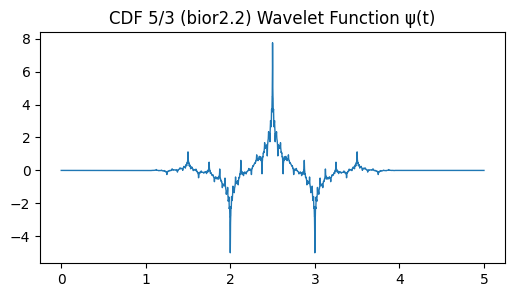

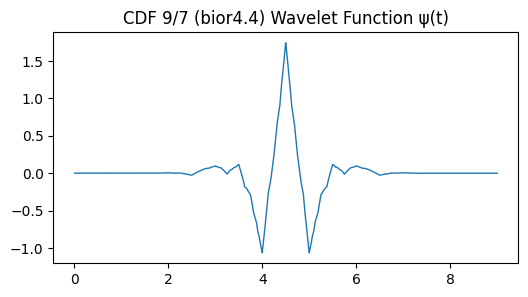

In [6]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

w = pywt.Wavelet('bior2.2')

dir = "img/"
# wavefun untuk bior menghasilkan 5 nilai
phi, psi, phi_r, psi_r, x = w.wavefun(level=10)

plt.figure(figsize=(6,3))
plt.plot(x, psi, linewidth=1.0)
plt.grid(False)
plt.savefig(dir + "CDF 5_3 (bior2.2).png")
plt.title("CDF 5/3 (bior2.2) Wavelet Function ψ(t)")
plt.show()


# Wavelet CDF 9/7
w = pywt.Wavelet('bior4.4')

# wavefun() mengembalikan 5 nilai untuk biorthogonal wavelets
phi, psi, phi_r, psi_r, x = w.wavefun(level=10)

# Plot wavelet function ψ(t)
plt.figure(figsize=(6,3))
plt.plot(x, psi, linewidth=1.0)
plt.grid(False)
plt.savefig(dir + "CDF 9_7 (bior4.4).png")
plt.title("CDF 9/7 (bior4.4) Wavelet Function ψ(t)")
plt.show()


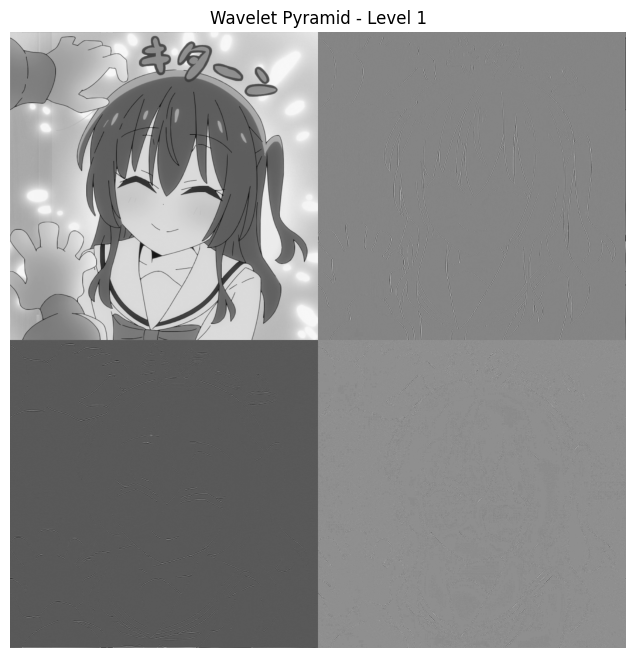

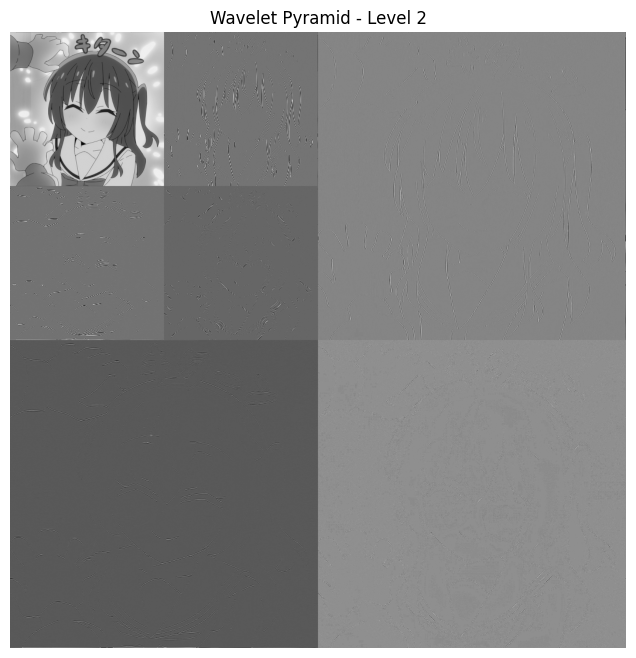

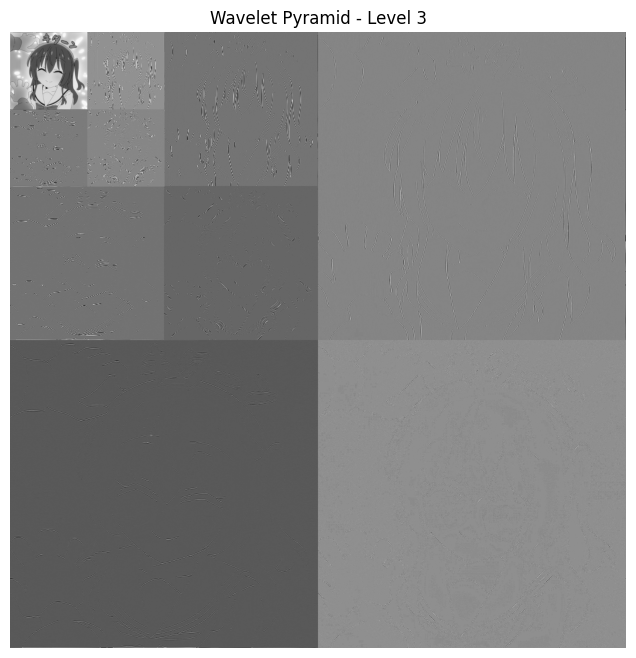

In [16]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ================================
# Load image
# ================================
dir = "img/"
img = Image.open(dir + "kita_shine.png").convert("L")
img = np.array(img, dtype=np.float32)

# ================================
# Normalisasi untuk ditampilkan
# ================================
def norm(b):
    mn, mx = b.min(), b.max()
    if mx - mn == 0:
        return np.zeros_like(b)
    return (b - mn) / (mx - mn)

# ================================
# Compute DWT level 1, 2, 3
# ================================
wave = "bior4.4"

# Level 1
LL1, (LH1, HL1, HH1) = pywt.dwt2(img, wave, mode="periodization")

# Level 2 (dari LL1)
LL2, (LH2, HL2, HH2) = pywt.dwt2(LL1, wave, mode="periodization")

# Level 3 (dari LL2)
LL3, (LH3, HL3, HH3) = pywt.dwt2(LL2, wave, mode="periodization")


# ======================================================
#                  LEVEL 1 PYRAMID
# ======================================================
def pyramid_level1():
    h1, w1 = LL1.shape
    canvas = np.zeros((h1*2, w1*2), dtype=np.float32)

    canvas[0:h1,      0:w1]     = norm(LL1)
    canvas[0:h1,      w1:2*w1]  = norm(HL1)
    canvas[h1:2*h1,   0:w1]     = norm(LH1)
    canvas[h1:2*h1,   w1:2*w1]  = norm(HH1)

    return canvas


# ======================================================
#                  LEVEL 2 PYRAMID (nested)
# ======================================================
def pyramid_level2():
    h1, w1 = LL1.shape
    canvas = np.zeros((h1*2, w1*2), dtype=np.float32)

    # Level 1 bands
    canvas[0:h1,       0:w1]      = norm(LL1)
    canvas[0:h1,       w1:2*w1]   = norm(HL1)
    canvas[h1:2*h1,    0:w1]      = norm(LH1)
    canvas[h1:2*h1,    w1:2*w1]   = norm(HH1)

    # Level 2 inside LL1 zone
    h2, w2 = LL2.shape
    canvas[0:h2,       0:w2]      = norm(LL2)
    canvas[0:h2,       w2:2*w2]   = norm(HL2)
    canvas[h2:2*h2,    0:w2]      = norm(LH2)
    canvas[h2:2*h2,    w2:2*w2]   = norm(HH2)

    return canvas


# ======================================================
#                  LEVEL 3 PYRAMID (nested)
# ======================================================
def pyramid_level3():
    h1, w1 = LL1.shape
    canvas = np.zeros((h1*2, w1*2), dtype=np.float32)

    # Level 1
    canvas[0:h1,      0:w1]      = norm(LL1)
    canvas[0:h1,      w1:2*w1]   = norm(HL1)
    canvas[h1:2*h1,   0:w1]      = norm(LH1)
    canvas[h1:2*h1,   w1:2*w1]   = norm(HH1)

    # Level 2 inside LL1
    h2, w2 = LL2.shape
    canvas[0:h2,       0:w2]      = norm(LL2)
    canvas[0:h2,       w2:2*w2]   = norm(HL2)
    canvas[h2:2*h2,    0:w2]      = norm(LH2)
    canvas[h2:2*h2,    w2:2*w2]   = norm(HH2)

    # Level 3 inside LL2
    h3, w3 = LL3.shape
    canvas[0:h3,       0:w3]      = norm(LL3)
    canvas[0:h3,       w3:2*w3]   = norm(HL3)
    canvas[h3:2*h3,    0:w3]      = norm(LH3)
    canvas[h3:2*h3,    w3:2*w3]   = norm(HH3)

    return canvas


# ======================================================
# Display all 3 pyramids
# ======================================================
plt.figure(figsize=(8,8))
plt.imshow(pyramid_level1(), cmap='gray')
plt.title("Wavelet Pyramid - Level 1")
plt.axis("off")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(pyramid_level2(), cmap='gray')
plt.title("Wavelet Pyramid - Level 2")
plt.axis("off")
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(pyramid_level3(), cmap='gray')
plt.title("Wavelet Pyramid - Level 3")
plt.axis("off")
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from math import log10
import pywt  # pastikan PyWavelets sudah ter-install

# =========================================================
# 1. METRIK: MSE, PSNR, SSIM
# =========================================================
def mse(a, b):
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    return np.mean((a - b) ** 2)

def psnr(a, b):
    m = mse(a, b)
    return 100 if m == 0 else 20 * log10(255.0 / np.sqrt(m))

def ssim(a, b):
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    C1, C2 = (0.01 * 255) ** 2, (0.03 * 255) ** 2
    mu1, mu2 = a.mean(), b.mean()
    s1 = ((a - mu1) ** 2).mean()
    s2 = ((b - mu2) ** 2).mean()
    s12 = ((a - mu1) * (b - mu2)).mean()
    return ((2 * mu1 * mu2 + C1) * (2 * s12 + C2)) / (
        (mu1 ** 2 + mu2 ** 2 + C1) * (s1 + s2 + C2)
    )

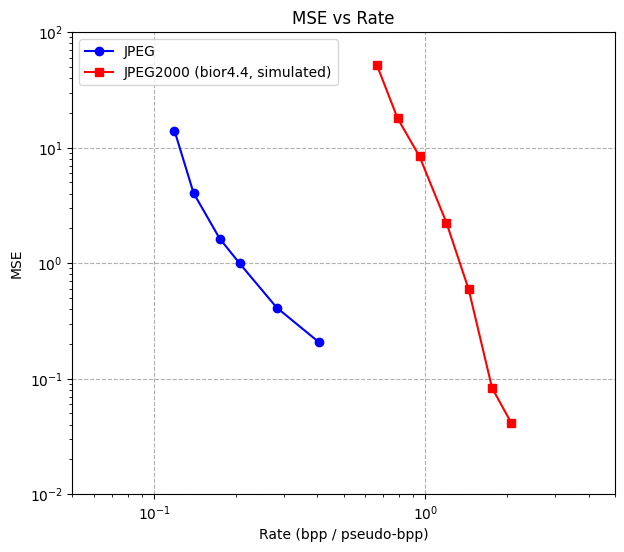

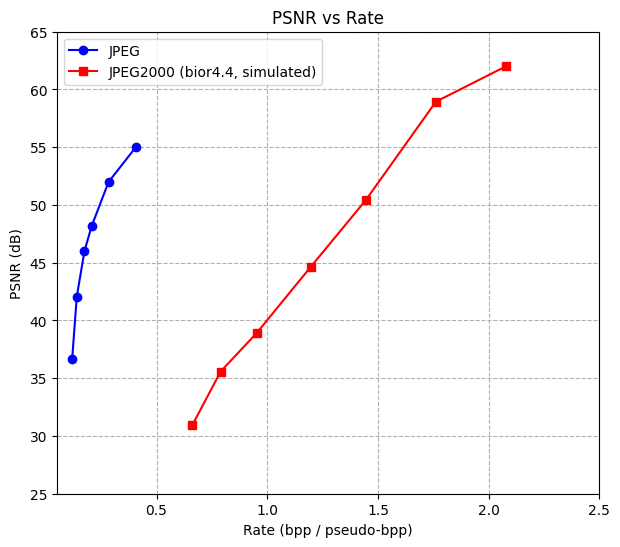

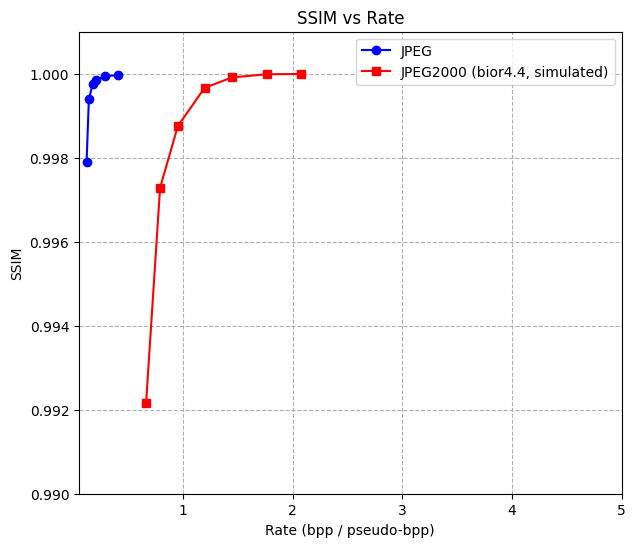

In [13]:
# =====================================
# Load gambar
# =====================================
dir = "img/"
img = Image.open(dir + "seiza_ni_naretara.png").convert("L")
img = np.array(img)
h, w = img.shape

jpeg_q = [10, 20, 40, 60, 80, 90]

rate_jpeg, mse_jpeg, psnr_jpeg, ssim_jpeg = [], [], [], []

for q in jpeg_q:
    buf = BytesIO()
    Image.fromarray(img.astype(np.uint8)).save(buf, format="JPEG", quality=q)
    data = buf.getvalue()
    comp = np.array(Image.open(BytesIO(data)).convert("L"), dtype=np.float32)

    rate = len(data) * 8 / (h * w)   # bits per pixel riil
    rate_jpeg.append(rate)
    mse_jpeg.append(mse(img, comp))
    psnr_jpeg.append(psnr(img, comp))
    ssim_jpeg.append(ssim(img, comp))

# =========================================================
# 4. “JPEG2000 lossy” – pakai DWT 9/7 (bior4.4) dari PyWavelets
#    1-level DWT 2D, quantization scalar sederhana
# =========================================================
# Step quantization: makin besar Q → kompresi lebih kuat (PSNR turun)
quant_steps = [50, 30, 20, 10, 5, 2, 1]

rate_j2k, mse_j2k, psnr_j2k, ssim_j2k = [], [], [], []

wavelet = pywt.Wavelet("bior4.4")   # CDF 9/7 kira-kira

for Q in quant_steps:
    # 1) DWT 2D level-1
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=1)
    cA, (cH, cV, cD) = coeffs

    # 2) Quantization umum (semua subband pakai step Q),
    #    kalau mau lebih realistis, bisa pakai step berbeda per subband.
    qA = np.round(cA / Q)
    qH = np.round(cH / Q)
    qV = np.round(cV / Q)
    qD = np.round(cD / Q)

    # 3) Estimasi rate: karena DWT kritis, total jumlah koefisien ~ jumlah piksel
    all_q = np.concatenate(
        [qA.ravel(), qH.ravel(), qV.ravel(), qD.ravel()]
    )
    # "pseudo-bpp" berdasarkan panjang kode bilangan bulat
    bits_per_coeff = np.mean(np.ceil(np.log2(1 + np.abs(all_q))))
    rate = bits_per_coeff  # ~ bits/pixel
    rate_j2k.append(rate)

    # 4) De-quantize
    rA = qA * Q
    rH = qH * Q
    rV = qV * Q
    rD = qD * Q

    # 5) Rekonstruksi via inverse DWT
    recon = pywt.waverec2((rA, (rH, rV, rD)), wavelet=wavelet)
    recon = np.clip(recon, 0, 255).astype(np.float32)

    # 6) Hitung metrik
    mse_j2k.append(mse(img, recon))
    psnr_j2k.append(psnr(img, recon))
    ssim_j2k.append(ssim(img, recon))

# =========================================================
# 5. PLOT – JPEG vs “JPEG2000” (bior4.4 + quant)
# =========================================================

# ---- MSE vs Rate (log–log)
plt.figure(figsize=(7, 6))
plt.loglog(rate_jpeg, mse_jpeg, "o-b", label="JPEG")
plt.loglog(rate_j2k,  mse_j2k,  "s-r", label="JPEG2000 (bior4.4, simulated)")
plt.xlabel("Rate (bpp / pseudo-bpp)")
plt.ylabel("MSE")
plt.grid(True, ls="--")
plt.xlim(0.05, 5)
plt.ylim(0.01, 100)
plt.legend()
plt.savefig(dir + "MSE vs Rate.png")
plt.title("MSE vs Rate")
plt.show()

# ---- PSNR vs Rate
plt.figure(figsize=(7, 6))
plt.plot(rate_jpeg, psnr_jpeg, "o-b", label="JPEG")
plt.plot(rate_j2k,  psnr_j2k,  "s-r", label="JPEG2000 (bior4.4, simulated)")
plt.xlabel("Rate (bpp / pseudo-bpp)")
plt.ylabel("PSNR (dB)")
plt.grid(True, ls="--")
plt.xlim(0.05, 2.5)
plt.ylim(25, 65)
plt.legend()
plt.savefig(dir + "PSNR vs Rate.png")
plt.title("PSNR vs Rate")
plt.show()

# ---- SSIM vs Rate
plt.figure(figsize=(7, 6))
plt.plot(rate_jpeg, ssim_jpeg, "o-b", label="JPEG")
plt.plot(rate_j2k,  ssim_j2k,  "s-r", label="JPEG2000 (bior4.4, simulated)")
plt.xlabel("Rate (bpp / pseudo-bpp)")
plt.ylabel("SSIM")
plt.grid(True, ls="--")
plt.xlim(0.05, 5)
plt.ylim(0.99, 1.001)
plt.legend()
plt.savefig(dir + "SSIM vs Rate.png")
plt.title("SSIM vs Rate")
plt.show()